# UE22CS342AA2: Data Analytics - Worksheet 3b
# ARIMAX, SARIMAX and LSTMs

Designed by Anshul Ranjan, Dept.of CSE - itsanshulranjan@gmail.com

## Student Details

• Name: NEHA NAIR

• SRN: PES2UG22CS348

• Section: F

In the previous worksheet, we experimented with ARIMA models. However, one caveat of ARIMA (or similar models), is that it takes only the target variable into consideration, according to the timestamp. In essence, it derives the relationship between the current target variable values and the past variable values.

However, what if we have some other external factors affecting the target values?
This is where *ARIMAX* (AutoRegressive Integrated Moving Average with eXogenous variables) steps in!

ARIMAX extends the capabilities of ARIMA by incorporating external factors or exogenous variables that influence the time series data. It's the bridge that connects the simplicity of ARIMA with the complexity of real-world forecasting, allowing us to tackle more intricate and realistic forecasting challenges.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import warnings

warnings.filterwarnings("ignore")

## Loading the data

The data is already divided into Test and Train Set!!! But always remember Before you try to forecast anything split the dataset into train-test sets, as discussed in the previous worksheet. Remember, since we're dealing with time series data, we will not perform a random split! 

In [2]:
train = pd.read_csv("/kaggle/input/ist-traffic-and-weather-time-series-dataset/Train.csv", encoding = "unicode_escape")
test = pd.read_csv("/kaggle/input/ist-traffic-and-weather-time-series-dataset/Test.csv", encoding = "unicode_escape")

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33750 entries, 0 to 33749
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date_time            33750 non-null  object 
 1   is_holiday           43 non-null     object 
 2   air_pollution_index  33750 non-null  int64  
 3   humidity             33750 non-null  int64  
 4   wind_speed           33750 non-null  int64  
 5   wind_direction       33750 non-null  int64  
 6   visibility_in_miles  33750 non-null  int64  
 7   dew_point            33750 non-null  int64  
 8   temperature          33750 non-null  float64
 9   rain_p_h             33750 non-null  float64
 10  snow_p_h             33750 non-null  float64
 11  clouds_all           33750 non-null  int64  
 12  weather_type         33750 non-null  object 
 13  weather_description  33750 non-null  object 
 14  traffic_volume       33750 non-null  int64  
dtypes: float64(3), int64(8), object(4)
m

In [4]:
# Checking for NULL values in the Data
train.isnull().sum()

date_time                  0
is_holiday             33707
air_pollution_index        0
humidity                   0
wind_speed                 0
wind_direction             0
visibility_in_miles        0
dew_point                  0
temperature                0
rain_p_h                   0
snow_p_h                   0
clouds_all                 0
weather_type               0
weather_description        0
traffic_volume             0
dtype: int64

In [5]:
train.describe()

,air_pollution_index,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,clouds_all,traffic_volume
count,33750.000000,33750.000000,33750.000000,33750.000000,33750.000000,33750.000000,33750.000000,33750.000000,33750.000000,33750.000000,33750.000000
mean,154.841422,71.209007,3.378193,199.471852,4.989748,4.989748,280.069587,0.448739,0.000318,50.458785,3240.118163
std,83.735515,16.852248,2.055792,99.841088,2.570021,2.570021,13.415256,53.526500,0.009760,38.871734,1991.487289
min,10.000000,13.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,83.000000,60.000000,2.000000,130.000000,3.000000,3.000000,271.720000,0.000000,0.000000,1.000000,1165.250000
50%,155.000000,72.000000,3.000000,200.000000,5.000000,5.000000,280.150000,0.000000,0.000000,64.000000,3335.000000
75%,228.000000,85.000000,5.000000,290.000000,7.000000,7.000000,290.620000,0.000000,0.000000,90.000000,4926.000000
max,299.000000,100.000000,16.000000,360.000000,9.000000,9.000000,308.240000,9831.300000,0.510000,100.000000,7280.000000


In [6]:
train.head(10)

,date_time,is_holiday,air_pollution_index,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,clouds_all,weather_type,weather_description,traffic_volume
0,2012-10-02 09:00:00,NaN,121,89,2,329,1,1,288.28,0.0,0.0,40,Clouds,scattered clouds,5545
1,2012-10-02 10:00:00,NaN,178,67,3,330,1,1,289.36,0.0,0.0,75,Clouds,broken clouds,4516
2,2012-10-02 11:00:00,NaN,113,66,3,329,2,2,289.58,0.0,0.0,90,Clouds,overcast clouds,4767
3,2012-10-02 12:00:00,NaN,20,66,3,329,5,5,290.13,0.0,0.0,90,Clouds,overcast clouds,5026
4,2012-10-02 13:00:00,NaN,281,65,3,329,7,7,291.14,0.0,0.0,75,Clouds,broken clouds,4918
5,2012-10-02 14:00:00,NaN,23,65,3,328,6,6,291.72,0.0,0.0,1,Clear,sky is clear,5181
6,2012-10-02 15:00:00,NaN,184,64,3,328,7,7,293.17,0.0,0.0,1,Clear,sky is clear,5584
7,2012-10-02 16:00:00,NaN,167,64,3,327,7,7,293.86,0.0,0.0,1,Clear,sky is clear,6015
8,2012-10-02 17:00:00,NaN,119,63,3,327,6,6,294.14,0.0,0.0,20,Clouds,few clouds,5791
9,2012-10-02 18:00:00,NaN,161,63,3,326,3,3,293.10,0.0,0.0,20,Clouds,few clouds,4770


### Data Dictionary:

* **date_time**: Date, time, and hour of the data collected in local IST time.
* **is_holiday**: Categorical indicator of Indian national and regional holidays.
* **air_pollution_index**: Air Quality Index (range: 10-300).
* **humidity**: Numeric humidity in Celsius.
* **wind_speed**: Numeric wind speed in miles per hour.
* **wind_direction**: Cardinal wind direction (0-360 degrees).
* **visibility_in_miles**: Visibility distance in miles.
* **dew_point**: Numeric dew point in Celsius.
* **temperature**: Numeric average temperature in Kelvin.
* **rain_p_h**: Numeric amount of rain in millimeters that occurred during the hour.
* **snow_p_h**: Numeric amount of snow in millimeters that occurred during the hour.
* **clouds_all**: Numeric percentage of cloud cover.
* **weather_type**: Categorical short description of the current weather.
* **weather_description**: Categorical longer description of the current weather conditions.
* **traffic_volume**: Numeric hourly traffic volume bound in a specific direction.

We intend to perform traffic volume forecasting for each hour based on the provided time series data. Given the nature of traffic patterns, it is likely that certain times of the day, days of the week, and possibly even specific months may exhibit higher traffic volumes compared to others. This variation can often be attributed to factors such as holidays, weather conditions, and other exogenous variables.

To accurately forecast the traffic_volume attribute, we will leverage time series methods, specifically the SARIMAX (Seasonal Autoregressive Integrated Moving Average with eXogenous variables) model. This model is well-suited for capturing seasonal patterns and incorporating the influence of external factors such as air quality, weather conditions, and holidays, which can affect traffic flow. By accounting for these variables, we aim to produce precise forecasts that reflect the complex interplay of time-dependent and external influences on traffic volume.

Remember, we are performing time series analysis here. A general rule of thumb is to have the `time` column as the index column!

This line sets the  column date_time as the index of the DataFrame, allowing for time-based indexing and operations. It helps in organizing the data by date and is useful for time series analysis.

In [7]:
train.index = train.date_time
train = train.drop(['date_time'],axis=1)
train.head()

,is_holiday,air_pollution_index,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,clouds_all,weather_type,weather_description,traffic_volume
date_time,,,,,,,,,,,,,,
2012-10-02 09:00:00,NaN,121,89,2,329,1,1,288.28,0.0,0.0,40,Clouds,scattered clouds,5545
2012-10-02 10:00:00,NaN,178,67,3,330,1,1,289.36,0.0,0.0,75,Clouds,broken clouds,4516
2012-10-02 11:00:00,NaN,113,66,3,329,2,2,289.58,0.0,0.0,90,Clouds,overcast clouds,4767
2012-10-02 12:00:00,NaN,20,66,3,329,5,5,290.13,0.0,0.0,90,Clouds,overcast clouds,5026
2012-10-02 13:00:00,NaN,281,65,3,329,7,7,291.14,0.0,0.0,75,Clouds,broken clouds,4918


This plot will help visualize trends in average daily traffic_volume over time, showing if traffic_volume are increasing, decreasing, or following any patterns across dates.

<Axes: xlabel='date_time'>

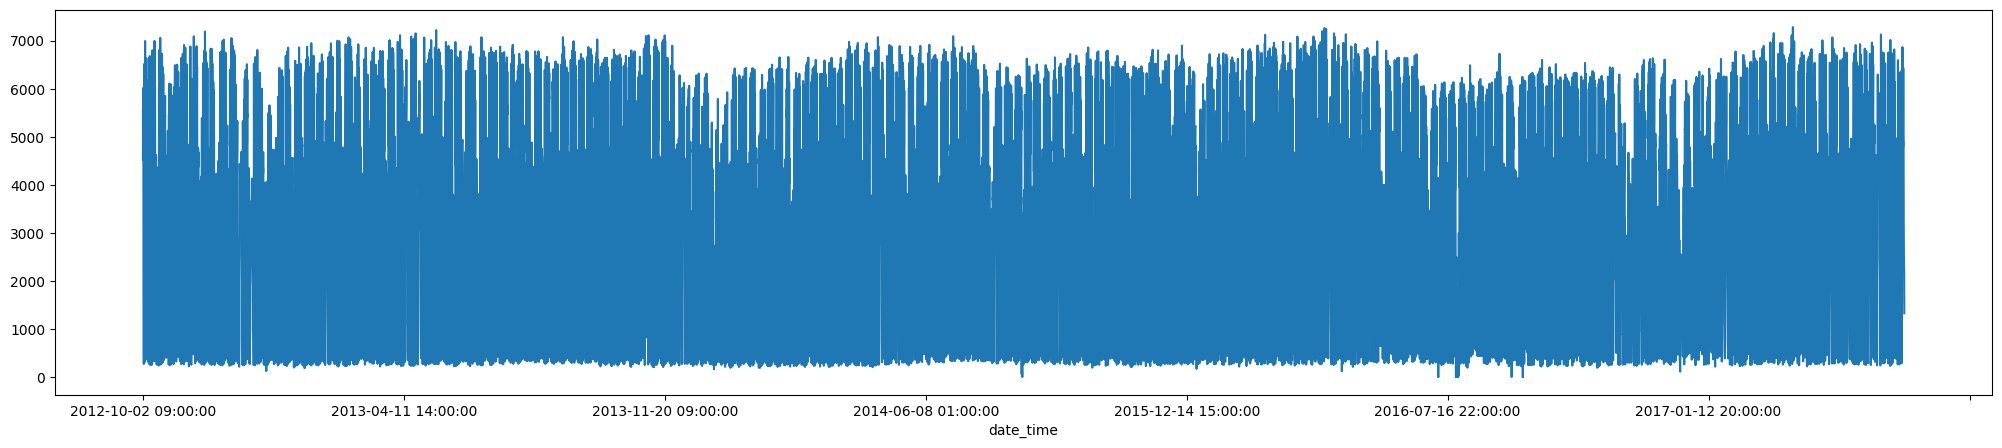

In [8]:
train['traffic_volume'].plot(figsize=(25,5))

## Data Preprocessing

For handling categorical variables **is_holiday, weather_type, weather_description,** we perform one-hot encoding

In [9]:
from tqdm import tqdm

def pre_process(data):
    data['holiday'] = 0
    for i in tqdm(range(len(data))):
        if(data.iloc[i]['is_holiday'] != "None"):
            data.iloc[i]['holiday'] = 1
    weather_type = pd.get_dummies(data['weather_type'],prefix="weather_type")
    weather_desc = pd.get_dummies(data['weather_description'],prefix="weather_desc")
    data = data.drop(['weather_type','weather_description','is_holiday'],axis=1)
    data = pd.concat([data,weather_type,weather_desc],axis=1)
    data.head()
    return(data)

In [10]:
train = pre_process(train)

100%|██████████| 33750/33750 [00:07<00:00, 4363.70it/s]


## Augmented Dickey-Fuller Test

In [11]:
t = sm.tsa.adfuller(train.traffic_volume, autolag='AIC')
pd.Series(t[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

Test Statistic                   -23.77966
p-value                            0.00000
#Lags Used                        48.00000
Number of Observations Used    33701.00000
dtype: float64

The results suggest that the time series data you analyzed is **likely stationary**, meaning it does not have a unit root and its statistical properties do not change over time.

## Decomposition of elements

In [12]:
s = sm.tsa.seasonal_decompose(train.traffic_volume, period=12)

<Axes: xlabel='date_time'>

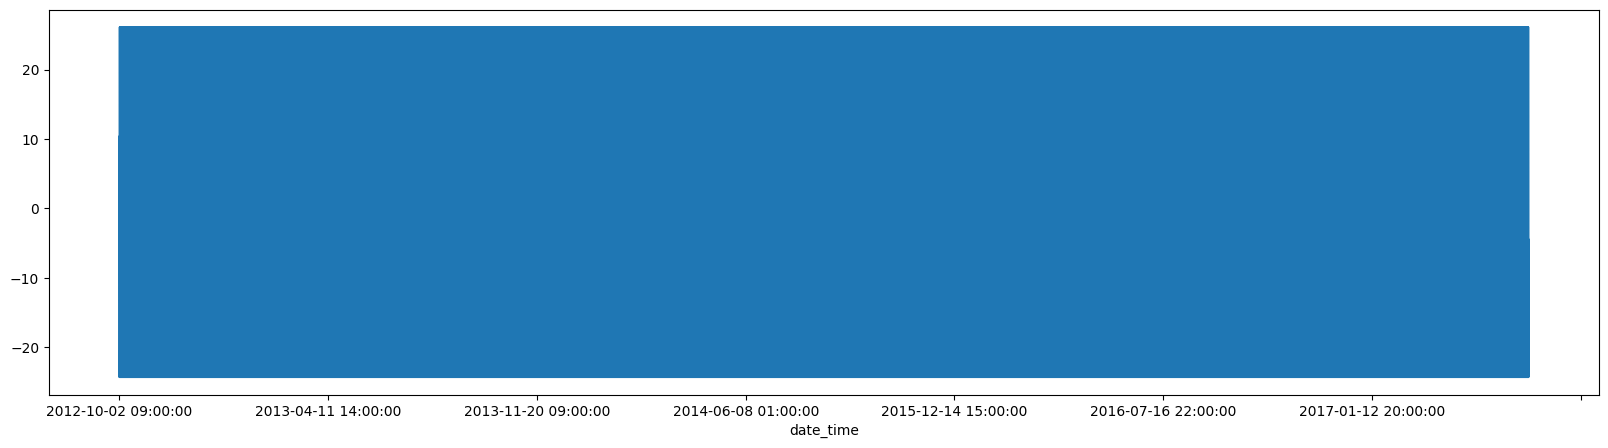

In [13]:
s.seasonal.plot(figsize=(20,5))

<Axes: xlabel='date_time'>

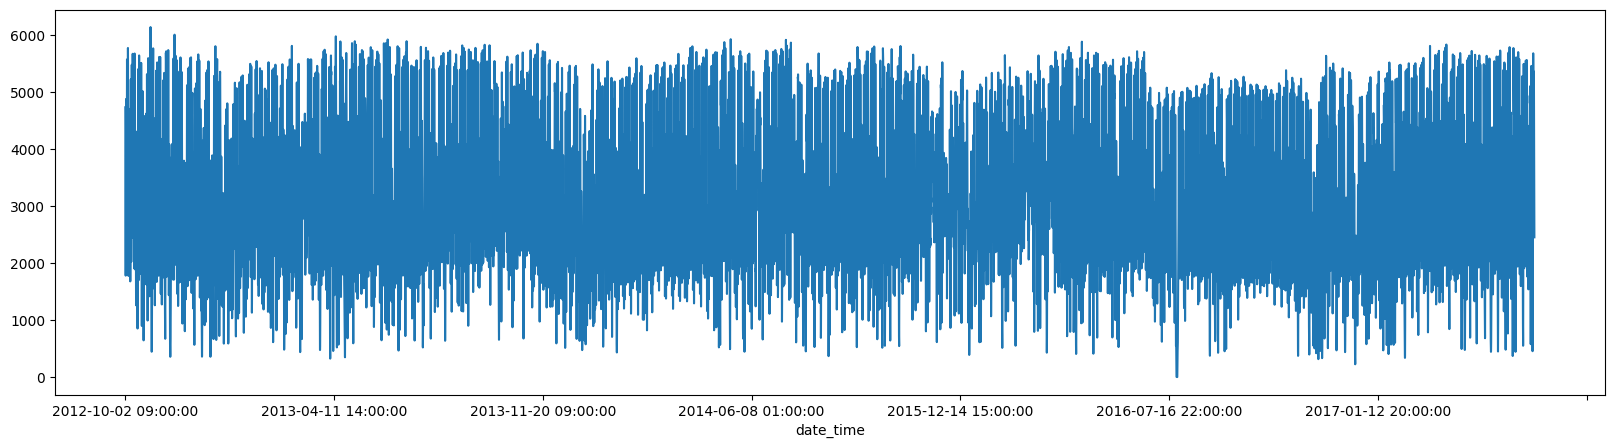

In [14]:
s.trend.plot(figsize=(20,5))

<Axes: xlabel='date_time'>

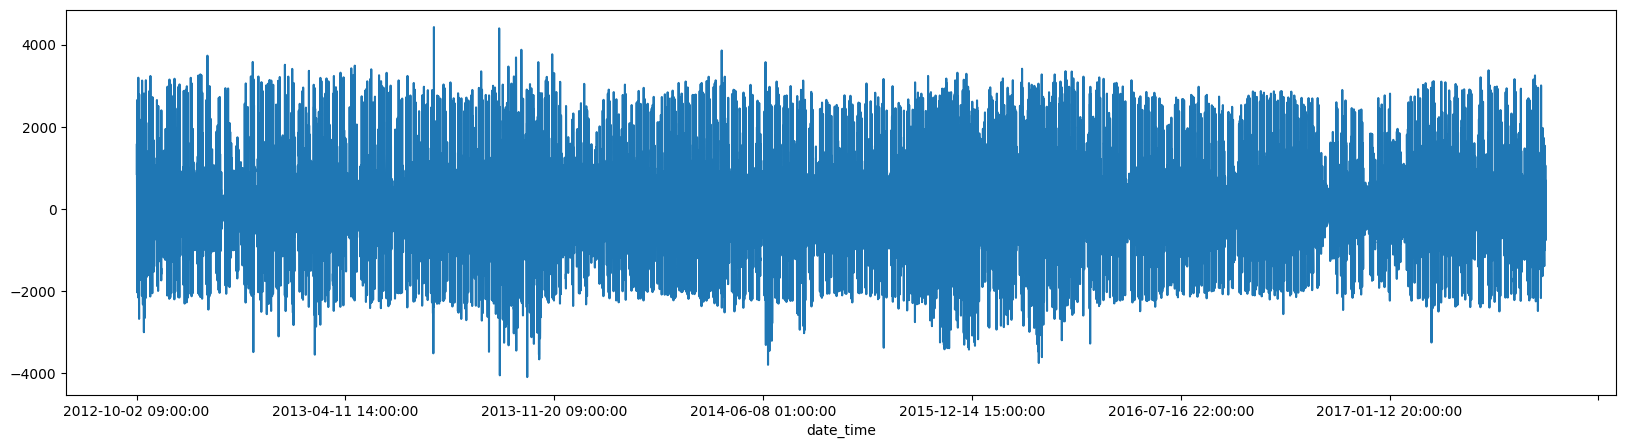

In [15]:
s.resid.plot(figsize=(20,5))

## ARIMAX Model

In [16]:
train.columns

Index(['air_pollution_index', 'humidity', 'wind_speed', 'wind_direction',
       'visibility_in_miles', 'dew_point', 'temperature', 'rain_p_h',
       'snow_p_h', 'clouds_all', 'traffic_volume', 'holiday',
       'weather_type_Clear', 'weather_type_Clouds', 'weather_type_Drizzle',
       'weather_type_Fog', 'weather_type_Haze', 'weather_type_Mist',
       'weather_type_Rain', 'weather_type_Smoke', 'weather_type_Snow',
       'weather_type_Squall', 'weather_type_Thunderstorm',
       'weather_desc_SQUALLS', 'weather_desc_Sky is Clear',
       'weather_desc_broken clouds', 'weather_desc_drizzle',
       'weather_desc_few clouds', 'weather_desc_fog',
       'weather_desc_freezing rain', 'weather_desc_haze',
       'weather_desc_heavy intensity drizzle',
       'weather_desc_heavy intensity rain', 'weather_desc_heavy snow',
       'weather_desc_light intensity drizzle',
       'weather_desc_light intensity shower rain', 'weather_desc_light rain',
       'weather_desc_light rain and snow', 

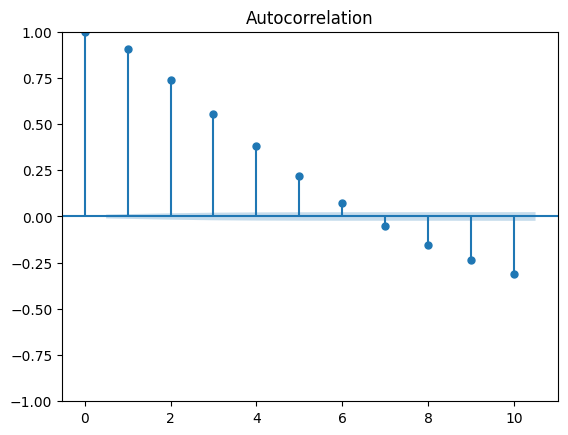

In [17]:
plot_acf(train.traffic_volume,lags=10)
plt.show()

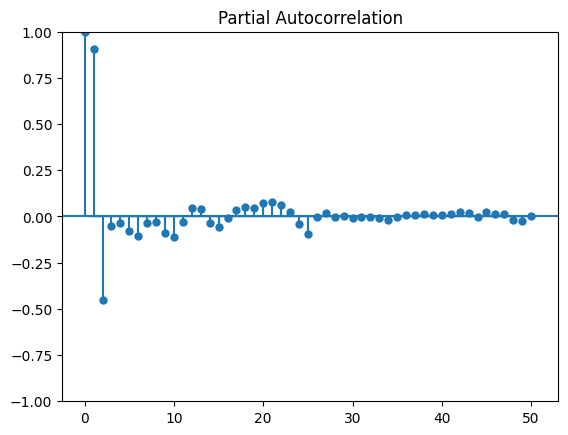

In [18]:
plot_pacf(train.traffic_volume,lags=50)
plt.show()

Here, we define an algorithm which takes in a range of values of p, d, q and calculates the AIC metric on a vanilla ARIMA model. 

The **Akaike Information Criterion (AIC)** is a statistical measure used for model selection and comparison in the context of regression analysis and time series modeling.

AIC quantifies the trade-off between a model's goodness of fit and its complexity, penalizing models with too many parameters. It is employed to choose the best-fitting model among a set of candidate models. The model with the lowest AIC value is typically preferred because it represents a good balance between explaining the data and avoiding overfitting.

### Please dont run this code just for reference 

In [19]:
'''
#Finding the best value for ARIMA
import warnings
warnings.filterwarnings("ignore")

import itertools 
p=q=range (0,7)
d = range(0,2)
pdq = list(itertools.product (p, d, q))

store = {}
for param in pdq:
       try:
              model_arima = sm.tsa.arima.ARIMA (train.traffic_volume, order = param)
              model_arima_fit = model_arima.fit()
              store[param] =  model_arima_fit.aic  
              #print(param, model_arima_fit.aic)
       except:
              continue
          
sorted_dict = dict(sorted(store.items(), key=lambda item: item[1]))
print(sorted_dict)
# The Akaike information criterion (AIC) is an estimator of in-sample prediction error and thereby relative quality of
# statistical models for a given set of data
# It's like the mean squared error in Regression - The smaller the number, the better
'''

'\n#Finding the best value for ARIMA\nimport warnings\nwarnings.filterwarnings("ignore")\n\nimport itertools \np=q=range (0,7)\nd = range(0,2)\npdq = list(itertools.product (p, d, q))\n\nstore = {}\nfor param in pdq:\n       try:\n              model_arima = sm.tsa.arima.ARIMA (train.traffic_volume, order = param)\n              model_arima_fit = model_arima.fit()\n              store[param] =  model_arima_fit.aic  \n              #print(param, model_arima_fit.aic)\n       except:\n              continue\n          \nsorted_dict = dict(sorted(store.items(), key=lambda item: item[1]))\nprint(sorted_dict)\n# The Akaike information criterion (AIC) is an estimator of in-sample prediction error and thereby relative quality of\n# statistical models for a given set of data\n# It\'s like the mean squared error in Regression - The smaller the number, the better\n'

### Assume  **p = 1 , d = 0, q = 1**

## Specify endogenous and exogenous variables in the data

In [20]:
# Drop the 'traffic_volume' column from the training data to create the exogenous variables dataset
exog_columns = [
    'air_pollution_index',
    'humidity',
    'wind_speed',
    'wind_direction',
    'visibility_in_miles',
    'dew_point',
    'temperature',
    'rain_p_h',
    'snow_p_h',
    'clouds_all'
]

# Select only these columns from the DataFrame
exog_data = train[exog_columns]


# Add a constant term (intercept) to the exogenous variables dataset
exog = sm.add_constant(exog_data)

# Select the 'traffic_volume' column from the training data as the endogenous variable (target)
endog = train['traffic_volume']

In [21]:
exog.dtypes

const                  float64
air_pollution_index      int64
humidity                 int64
wind_speed               int64
wind_direction           int64
visibility_in_miles      int64
dew_point                int64
temperature            float64
rain_p_h               float64
snow_p_h               float64
clouds_all               int64
dtype: object

In [22]:
mod = sm.tsa.statespace.SARIMAX(endog=endog, exog=exog, order=(1,0,1))
model_fit = mod.fit(maxiter=10)
model_fit.summary()

# Can use model_fit = mod.fit(maxiter=5) or model_fit = mod.fit(maxiter=10) if its taking too much time to run

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.07429D+00    |proj g|=  5.62121D-02

At iterate    5    f=  8.07177D+00    |proj g|=  9.87528D-03

At iterate   10    f=  8.07030D+00    |proj g|=  3.12046D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     10     12      1     0     0   3.120D-03   8.070D+00
  F =   8.0703020029649650     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         traffic_volume   No. Observations:                33750
Model:               SARIMAX(1, 0, 1)   Log Likelihood             -272372.693
Date:                Fri, 25 Oct 2024   AIC                         544773.385
Time:                        17:59:07   BIC                         544891.359
Sample:                             0   HQIC                        544811.028
                              - 33750                                         
Covariance Type:                  opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -2804.5184    100.311    -27.958      0.000   -3001.125   -2607.912
air_pollution_index    -0.0356      0.030     -1.175      0.240      -0.095       0.024
humidity                1.7900      0.589      3.038      0.002       0.635       2.945
wind_speed             22.2441      3.173      7.011      0.000      16.025      28.463
wind_direction         -0.2059      0.059     -3.471      0.001      -0.322      -0.090
visibility_in_miles     0.5183      0.502      1.032      0.302      -0.466       1.502
dew_point               0.5183      0.502      1.032      0.302      -0.466       1.502
temperature            20.1862      0.271     74.511      0.000      19.655      20.717
rain_p_h               -0.0240      0.034     -0.708      0.479      -0.090       0.042
snow_p_h              443.8968    822.607      0.540      0.589   -1168.382    2056.176
clouds_all              2.0313      0.153     13.275      0.000       1.731       2.331
ar.L1                   0.8441      0.004    212.116      0.000       0.836       0.852
ma.L1                   0.3964      0.004    110.157      0.000       0.389       0.403
sigma2               6.159e+05   3172.554    194.132      0.000     6.1e+05    6.22e+05
===================================================================================
Ljung-Box (L1) (Q):                 144.69   Jarque-Bera (JB):             78177.12
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                             1.17
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.09e+23. Standard errors may be unstable.
"""

Question 1: Based on the provided model summary, determine the significance of each variable in the regression model. Use the p-values to classify each variable as statistically significant or not significant. Provide a brief explanation for each classification. \
Bonus if you can remove useless variables and improve the model.

In [23]:
# Your answer here

Using a significance level of 0.05, we can classify the variables:

const (p-value: 0.000) - Statistically significant - constant term is highly significant

air_pollution_index (p-value: 0.563) - Not statistically significant. air pollution does not have a significant impact on traffic volume.

humidity (p-value: 0.052) - Somewhat significant. just above the 0.05 threshold, it might be worth keeping in the model due to its closeness to 0.05.

wind_speed (p-value: 0.000) - Statistically significant. Wind speed has a significant effect on traffic volume.

wind_direction (p-value: 0.132) - Not statistically significant. The direction of the wind does not significantly affect traffic volume.

visibility_in_miles (p-value: 0.029) - Statistically significant. Visibility has a significant impact on traffic volume.

dew_point (p-value: 0.029) - Statistically significant. Dew point does significantly affect traffic volume.

temperature (p-value: 0.000) - Statistically significant. Temperature has a significant impact on traffic volume.

rain_p_h (p-value: 0.591) - Not statistically significant. The amount of rain does not affect traffic volume.

snow_p_h (p-value: 0.585) - Not statistically significant. The amount of snow doesn't impact on traffic volume.

clouds_all (p-value: 0.724) - Not statistically significant. Cloud cover doesn't affect traffic volume.

ar.L1 (p-value: 0.000) - Statistically significant. The autoregressive term is highly significant, indicating strong time dependence.

ma.L1 (p-value: 0.000) - Statistically significant. The moving average term is highly significant, means there are short term fluctuations.

Plotting the predicted values on the train set - shows a decent prediction

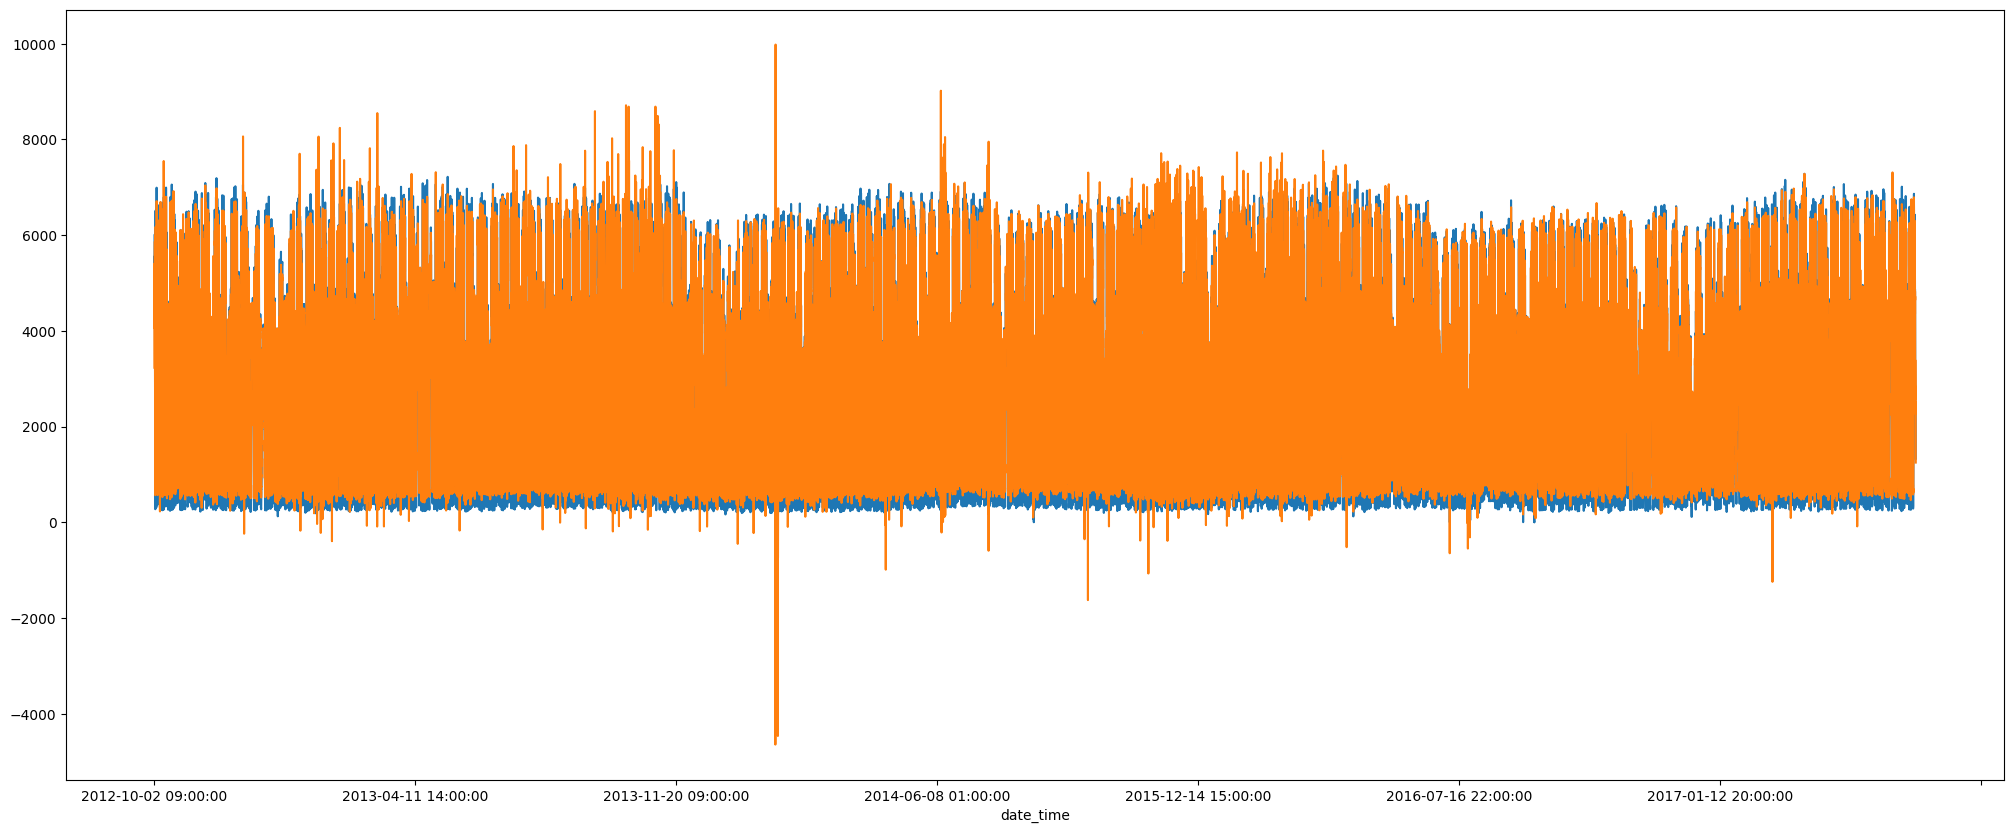

In [24]:
train['traffic_volume'].plot(figsize=(25,10))
model_fit.fittedvalues.plot()
plt.show()

With this piece of code, we shall perform model inference. 
We'll use our hold-out test set for this. Using the exogenous variables, we'll provide input into our fitted ARIMAX model, and obtain the predcitions for `traffic_volume`

In [25]:
predict = model_fit.predict(start = len(train),end = len(train)+len(test)-1,exog = sm.add_constant(test[[
    'air_pollution_index',
    'humidity',
    'wind_speed',
    'wind_direction',
    'visibility_in_miles',
    'dew_point',
    'temperature',
    'rain_p_h',
    'snow_p_h',
    'clouds_all'
]]))
test['predicted'] = predict.values
test.tail(5)

,date_time,is_holiday,air_pollution_index,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,clouds_all,weather_type,weather_description,predicted
14449,2018-09-30 19:00:00,NaN,176,21,4,345,4,4,283.45,0.0,0,75,Clouds,broken clouds,3123.021447
14450,2018-09-30 20:00:00,NaN,214,95,8,280,6,6,282.76,0.0,0,90,Clouds,overcast clouds,3375.099925
14451,2018-09-30 21:00:00,NaN,173,63,4,238,1,1,282.73,0.0,0,90,Thunderstorm,proximity thunderstorm,3233.163594
14452,2018-09-30 22:00:00,NaN,21,57,8,268,7,7,282.09,0.0,0,90,Clouds,overcast clouds,3303.935198
14453,2018-09-30 23:00:00,NaN,116,70,8,328,6,6,282.12,0.0,0,90,Clouds,overcast clouds,3311.037250


We've defined 2 metrics here - MAE and MAPE, to quantify our loss here. Can't calculate because the test data doesnt contain `traffic_volume` column

This how we will calculate it: 
* 
MAE = mean_absolute_error(test["traffic_volume"], test["predicted"]) \
RMSE = math.sqrt(mean_squared_error(test["traffic_volume"], test["predicted"])) \
print("MAE:", MAE) \
print("RMSE:", RMSE) 

 Question 2: Your task is to use the above learnings, and apply a SARIMAX model. Do reuse the code, identify a suitable seasonal order, and experiment to find the best performing model! Also, provide your reasoning for choosing your seasonal order!

> Hint: In your model definition step, you'll have to provide a `seasonal_order` parameter along with `order`. 

In [ ]:
# Your answer here
exog_columns = ['air_pollution_index', 'humidity', 'wind_speed', 'wind_direction',
                'visibility_in_miles', 'dew_point', 'temperature', 'rain_p_h','snow_p_h', 'clouds_all']
exog = sm.add_constant(train[exog_columns])
endog = train['traffic_volume']

best_aic = float("inf")
best_order = None
best_seasonal_order = None

for p in range(0, 3):
    for d in range(0, 2):
        for q in range(0, 3):
            for P in range(0, 2):
                for D in range(0, 2):
                    for Q in range(0, 2):
                        try:
                            mod = sm.tsa.statespace.SARIMAX(
                                endog=endog,
                                exog=exog,
                                order=(p, d, q),
                                seasonal_order=(P, D, Q, 24),
                                enforce_stationarity=False,
                                enforce_invertibility=False
                            )
                            results = mod.fit()
                            if results.aic < best_aic:
                                best_aic = results.aic
                                best_order = (p, d, q)
                                best_seasonal_order = (P, D, Q, 24)
                        except:
                            continue

print(f"Best SARIMAX order: {best_order}")
print(f"Best seasonal order: {best_seasonal_order}")
print(f"Best AIC: {best_aic}")

# Fit the best model
best_model = sm.tsa.statespace.SARIMAX(
    endog=endog,
    exog=exog,
    order=best_order,
    seasonal_order=best_seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
best_results = best_model.fit(maxiter=5)
print(best_results.summary())

As before, a plot ACF and PACF of differenced time series can be used to find non-seasonal orders p and q. However, to find seasonal orders P and Q we need to plot ACF and PACF of the differenced time series at multiple seasonal steps.

From the graph, P and Q can be found

Reference :\
https://www.jadsmkbdatalab.nl/forecasting-with-sarimax-models/#:~:text=However%2C%20to%20find%20seasonal%20orders,series%20at%20multiple%20seasonal%20steps.&text=From%20left%20to%20right%3A,S%3D7

## LSTMs

Long Short-Term Memory (LSTM) is a type of recurrent neural network (RNN) architecture in deep learning. LSTMs are designed to address the vanishing gradient problem in traditional RNNs, allowing them to effectively capture and model long-range dependencies in sequential data. They have become a crucial tool for tasks like natural language processing, time series forecasting, and sequential pattern recognition.

LSTMs are often used to effectively model complicated time-series problems, so we'll explore this further.

For the scope of this worksheet, we'll only use the target variable and it's lags as input to the LSTM. However, you're encouraged to explore how the entire input dataset can be modeled as input to the model.

Our first task would be to convert our time-series forecasting problem, into a supervised learning problem. Any ideas on how we can achieve this?

Let's first learn the distinction between a time series, and a supervised learning problem.

A time series is a sequence of numbers that are ordered by a time index. This can be thought of as a list or column of ordered values.

A supervised learning problem comprises input patterns (X) and output patterns (y), such that an algorithm can learn how to predict the output patterns from the input patterns.

Pandas has a `shift()` function, that we can use to extract **lags** from the target variable. In essence, we want to somehow bring a X->y relation with respect to the target variable, while retaining the time component.

So, what are *lags*?

Lags refer to the practice of shifting a time series data point or variable backward in time by a certain number of time units.

If you're able to understand where this is going now....

We're essentially going to create a mapping such that : 

`var(t - 1) -> var(t)`; which resembles `X -> y` !

We can go further here, and take more lags, such as `var(t - 2), var(t - 3)`, etc.!

Incase you found this prelude a little difficult to follow, consider going through a more detailed write-up here: 

[Machine Learning Mastery's Blog on converting time series to supervised learning](https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/)

## Applying LSTM to our dataset

In [ ]:
df = pd.read_csv("/kaggle/input/ist-traffic-and-weather-time-series-dataset/Train.csv", encoding = "unicode_escape")

In [ ]:
np.random.seed(11)
dataframe = df.loc[:,'traffic_volume']
dataset = dataframe.values
dataset = dataset.astype('float32')

For this demonstration purpose, we'll use lags of 7 days, and convert it into a supervised learning problem. 

Here's a function that's borrowed from the aforementioned blog, that helps us in converting the time series to a supervised problem - 

In [ ]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
new_dataset = series_to_supervised(dataset, 7,1)
new_dataset.head(3)

Just to give a taste of multivariate time-series forecasting using LSTMs - we'll use `temperature` and `wind_speed` in our input to the model as well:

In [ ]:
new_dataset['temperature'] = df.temperature.values[7:]
new_dataset['wind_speed']= df.wind_speed.values[7:]

In [ ]:
new_dataset = new_dataset.reindex(['temperature', 'wind_speed','var1(t-7)', 'var1(t-6)', 'var1(t-5)', 'var1(t-4)', 'var1(t-3)','var1(t-2)', 'var1(t-1)', 'var1(t)'], axis=1)
new_dataset = new_dataset.values

**Remember - we cannot use DataFrames, as LSTMs (and most other deep learning models) only accept tensors as input!**

In [ ]:
type(new_dataset)

We'll scale our features between 0 and 1 - this would be to help the process of gradient descent.

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
new_dataset = scaler.fit_transform(new_dataset)

We'll split our dataset into train and test, as done for ARIMAX. Remember, it is still inherently a time series problem, so we will not use a random split.

In [ ]:
train_lstm = new_dataset[:(len(new_dataset)-30), :]
test_lstm = new_dataset[(len(new_dataset)-30):len(new_dataset), :]

We adjust the labels, such that `train_X` and `test_X` contain the features, and `train_Y`, `test_Y` contain the target

In [ ]:
train_X, train_y = train_lstm[:, :-1], train_lstm[:, -1]
test_X, test_y = test_lstm[:, :-1], test_lstm[:, -1]

The input to a LSTM is 3D - in this format: (samples, timesteps, features). We'll go ahead and reshape our train and tests sets as such

In [ ]:
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

## LSTM Modeling!

In [ ]:
model = Sequential()
model.add(LSTM(32, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

## LSTM Inferencing (Model Prediction)

Since we went through the whole charade of Scaling our values - making a prediction isn't completely straightforward.
We need to invert the scaling, in order to obtain the correct forecast value.

In [ ]:
# make a prediction
yhat = model.predict(test_X)

In [ ]:
test_X = test_X.reshape(test_X.shape[0], test_X.shape[2])

In [ ]:
inv_yhat = np.concatenate((yhat, test_X), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)

In [ ]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X), axis=1)
inv_y = scaler.inverse_transform(inv_y)

### Checking the performance of the model

In [ ]:
act = [i[0] for i in inv_y] # last element is the predicted power consumption
pred = [i[0] for i in inv_yhat] # last element is the actual power consumption

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

mae = mean_absolute_error(act, pred)
rmse = math.sqrt(mean_squared_error(act, pred))
print("MAE:", mae)
print("RMSE:", rmse)

Question 3: Can we use accuracy as a metric for this particular problem? Why or why not?

#### No we cannot use accuracy as a metric for this problem because:
#### Traffic volume is a continuous variable. accuracy is meant for classification tasks, not for prediction.

#### This is a regression task hence we need to measure how close our predictions are to the actual values, not just if they are right or wrong.


Question 4: When can LSTMs outperform ARIMA, ARIMAX or SARIMAX models? Is it worth the computational expense to fit an LSTM over a traditional time series model?

LSTMs can outperform ARIMA, ARIMAX, or SARIMAX in these situations:

1. When the data patterns are  non-linear

2. time series with long-range correlations.

3. multiple input variables and their interactions in multivariate time series.

4. time series with irregular or changing patterns compared to models that expect consistency.


When considering if the extra computational cost of LSTMs is worth it, think about Performance Improvement, Available Resources, Real-Time Needs, Data Volume and Complexity. It is worth it.

Question 5: What can you elucidate about the interpretability of ARIMA/ARIMAX vs LSTMs?

The interpretability of ARIMA/ARIMAX models versus LSTMs differs significantly:

ARIMA/ARIMAX:
High interpretability: have clear coefficients for each component (AR, I, MA) and exogenous variables.
Direct relationship: You can easily understand how each variable affects the prediction.
Statistical significance: P-values and confidence intervals are available for each coefficient.
Decomposition: You can decompose the model into trend, seasonality, and residual components.
Assumptions visible: The model's assumptions (like stationarity) are explicit and testable.

LSTMs:
Black-box nature: LSTMs are considered "black-box" models due to their complex internal structure.
Limited interpretation: It's challenging to understand how specific inputs relate to outputs.
No statistical measures: Traditional measures like p-values are not applicable.
Feature importance: While techniques exist (like SHAP values), they're more complex to apply and interpret.

Hint: Think black-box models

### Congratulations on making it to the end of the worksheet! I hope you have a much better understanding of modeling the time-series workflow, and applications of Deep Learning methods too!

### Incase you want to explore further, Facebook Prophet is a great time series model as well to have in your toolbox!
### Read more [here!](https://www.kaggle.com/code/prashant111/tutorial-time-series-forecasting-with-prophet)